This notebook is for miscellaneous calculations.

https://math.stackexchange.com/questions/3894072/guessing-local-extrema-of-a-polynomial-given-its-roots 

In [10]:
import numpy as np
from scipy.stats import spearmanr, logistic, t as tstat
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from glob import glob
import os
import h5py
from utils.utils import plot_root_intervals, get_max

pd.set_option('display.max_columns', 150)

ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])

def get_proper_intervals(b, w):
    x_intervals = np.array([[-bi/wi if -bi/wi < (1-bi)/wi else (1-bi)/wi for bi, wi in zip(b, w)], 
                            [(1-bi)/wi if -bi/wi < (1-bi)/wi else -bi/wi for bi, wi in zip(b, w)],]).T
    return x_intervals

# Prediction on the common sites

In [41]:
#get weights from real clocks (from the first step)
clocks = pd.read_csv('clock_data/Thompson_Multi_BL6.tsv', sep='\t', index_col=0)
#method, alpha = 'bonferroni', 0.01
#n_corrected_sites = clocks['PearsonP'][multipletests(clocks['PearsonP'], method=method, alpha=alpha)[0]].shape[0]
#print(f'Survived after {method} correction {n_corrected_sites} sites at s.level={alpha}')

common_sites = pd.read_csv('tmp_sites_1Mcov.csv', index_col=0).index.tolist()
top_sites = clocks.loc[list(common_sites)]
top_sites = top_sites[top_sites['PearsonP'] < 0.05]
#get top n from them based on the absolute value of correlation
#top = 5000
#top_idx = clocks['PearsonR'].abs().sort_values(ascending=False)[:top].index
#top_sites = clocks.loc[top_idx]

#get weights and biases
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])
roots_ = -b_ / w_ #polynomial roots before single cell data
dist_ = np.diff(np.sort(roots_))

# make an artificial signle cell methylation data (sampled from binomial distribution)
p_nonmet = 0.5
mask = np.random.binomial(1, p=p_nonmet, size=top).astype(bool)

#change weights and biases based on 0 or 1 in methylation data (apply -1 if 0)
w = np.array([-wi if m==False else wi for m, wi in zip(mask, w_)])
b = np.array([1-bi if m==False else bi for m, bi in zip(mask, b_)])
roots = -b / w #polynomial roots after single cell data
dist = np.diff(np.sort(roots))

print('Correlation weights and biases before data', np.round(np.corrcoef(w_, b_)[0,1], 3))
print('Correlation weights and biases after data', np.round(np.corrcoef(w, b)[0,1], 3))
print('Median distance between roots before data:', np.round(np.median(dist_), 3))
print('Median distance between roots after data:', np.round(np.median(dist), 3))

Correlation weights and biases before data 0.943
Correlation weights and biases after data -0.892
Median distance between roots before data: 6.797
Median distance between roots after data: 172.751


In [46]:
meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

#PROPER INTERVAL IN SCOPE
eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
x_intervals = get_proper_intervals(b_, w_)
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
print('Interval of search:', interval_of_search)
############
zero_met_replacement = 0.001
one_met_replacement = 0.999
n_steps = 1000
x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        #coverage check
        if cell_df.shape[0] < 1_000_000: continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0:
            continue
        
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites][cell_name].values
        probs = []
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            if (p <= 0).any() or (p >= 1).any(): 
                p[p <= 0] = zero_met_replacement
                p[p >= 1] = one_met_replacement
                print('oops!')
            p = np.where(mask, p, 1-p)
            probs.append(np.log(p).sum())
        cell_ages.append(x[np.argmax(probs)])
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(np.mean(cell_df[cell_name]))
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

Interval of search: (-90.99133768430073, 225.26709819030486)


100%|██████████| 296/296 [01:49<00:00,  2.70it/s]


In [47]:
print(data.groupby('Stage').count().iloc[:, 0])
data.groupby('Stage').median()

Stage
E4.5    38
E5.5    70
E6.5    95
E7.5    80
Name: Ages, dtype: int64


,Ages,n_sites,p_empiric,p_empiric_full_cell
Stage,,,,
E4.5,-90.991338,5.0,0.0,0.245778
E5.5,-90.991338,5.0,0.0,0.725958
E6.5,-90.991338,5.0,0.0,0.766382
E7.5,-90.991338,5.0,0.0,0.754691


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

E4.5 v.s. E5.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.129e-01 U_stat=1.254e+03
E5.5 v.s. E6.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.027e-01 U_stat=3.442e+03
E6.5 v.s. E7.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.877e-01 U_stat=3.880e+03


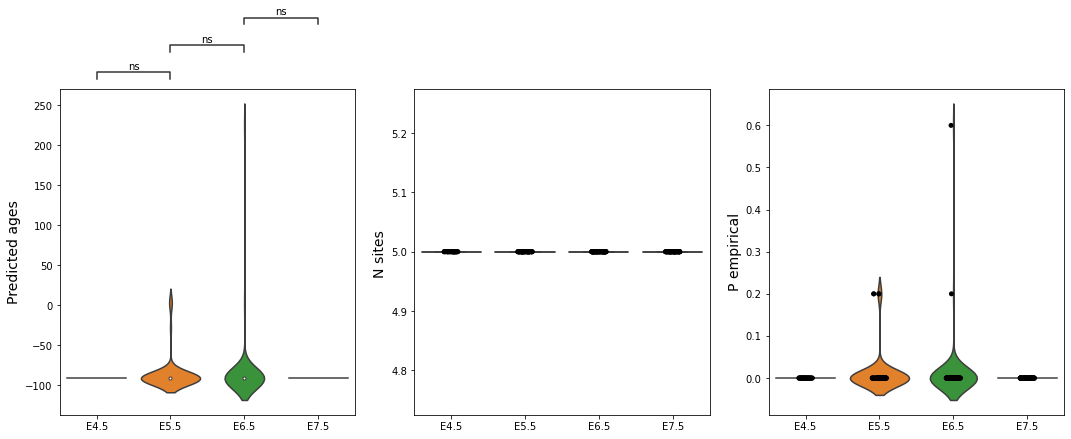

In [48]:
from statannot import add_stat_annotation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('E4.5', 'E5.5'), 
                                              ('E5.5', 'E6.5'),
                                              ('E6.5', 'E7.5')
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

**Conclusion:** we cannot estimate ages on common sites, because these sites have big variances in reference dataset.

**Idea:** we can use prior knowledge about methylation of cells to construct a prediction, if some site is absent in a cell, we change it with bernoulli random value sampled from the prior distribution of the cell methylation.

# Vizualizations of likelihood profiles within the proper interval

Interval of search: (3.8069075679530813, 18.743134560517827)


100%|██████████| 296/296 [02:20<00:00,  2.11it/s]


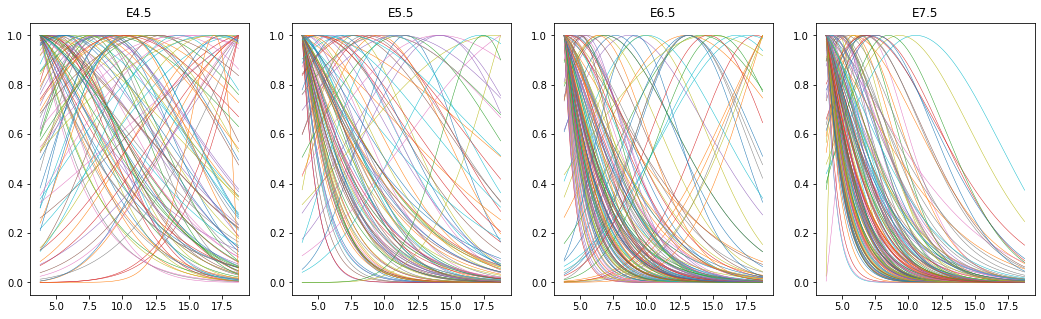

In [8]:
#get top n from them based on the absolute value of correlation
top = 5000
top_idx = clocks['PearsonR'].abs().sort_values(ascending=False)[:top].index
top_sites = clocks.loc[top_idx]
#get weights and biases
w_initial = np.asarray(top_sites['Coef'])
b_initial = np.asarray(top_sites['Intercept'])

meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

#PROPER INTERVAL IN SCOPE
eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
x_intervals = get_proper_intervals(b_initial, w_initial)
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
print('Interval of search:', interval_of_search)
############

n_steps = 1000
x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
cellinfo = dict(zip(stages, [{'w':[], 'b':[], 'm':[], 'age':[]} for _ in stages]))
for stage, ax in zip(stages, axes.flatten()):
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        #coverage check
        if cell_df.shape[0] < 500_000: continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0:
            continue
        
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites][cell_name].values
        #probs = []
        
        w = np.where(mask, w_, -w_)
        b = np.where(mask, b_, 1-b_)
        
        #ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
        ff = lambda x: np.prod([(wi*x + bi) for wi, bi in zip(w, b)])
        poly = np.asarray([ff(xi) for xi in x])
        poly = poly / np.max(poly)

        cellinfo[stage]['w'].append(w)
        cellinfo[stage]['b'].append(b)
        cellinfo[stage]['m'].append(mask)
        cellinfo[stage]['age'].append(x[np.argmax(poly)])
        ax.plot(x, poly, lw=0.5)
        ax.set_title(stage)
        # ax.set_yscale('log')

In [9]:
cellinfo['E4.5'].keys()

dict_keys(['w', 'b', 'm', 'age'])

/home/shappiron/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


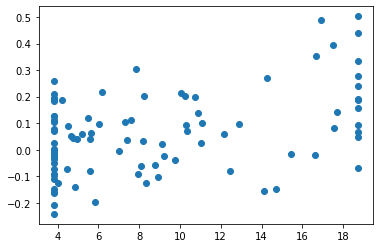

E4.5 0.06293800089240283 0.4466834723620735


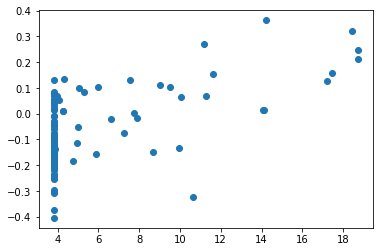

E5.5 -0.05802815953450187 0.5573238603214907


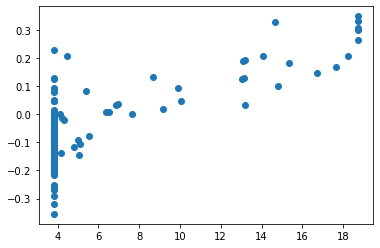

E6.5 -0.04398764391696099 0.7400207712126025


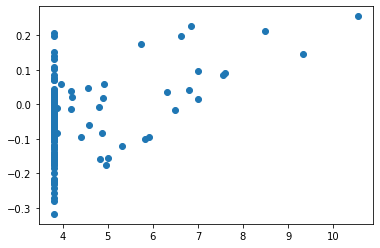

E7.5 -0.045282883389750866 0.441305867708235


In [29]:
#correlation of weights and methylation
from scipy.stats import spearmanr

sstat = []
for s in stages:
    n = len(cellinfo[s]['w']) #n cells
    ages = cellinfo[s]['age']
    scorr = []
    for c in range(n):
        cw = cellinfo[s]['w'][c]
        cm = cellinfo[s]['m'][c]
        r = spearmanr(cw, cm)[0]
        if np.isnan(r) == False:
            scorr.append(r)
        else:
            scorr.append(0.)
    sstat.append(scorr)
    plt.scatter(ages, scorr)
    plt.show()
    print(s, np.nanmean(scorr), np.corrcoef(ages, scorr)[0,1])
    

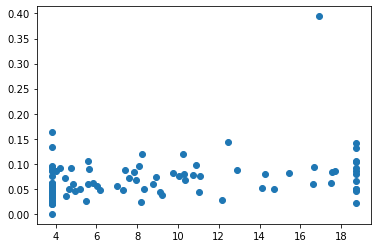

E4.5 0.3441199439081396


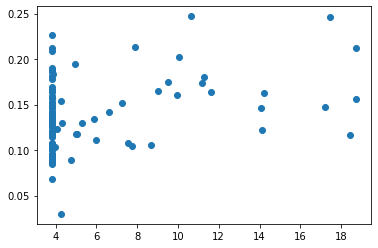

E5.5 0.23818966001349176


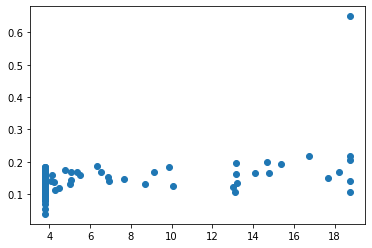

E6.5 0.43810601904334523


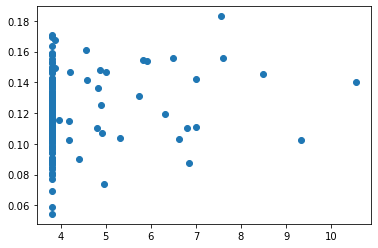

E7.5 0.17920216240584586


In [33]:
#correlation of mean methylation and ages

sstat = []
for s in stages:
    n = len(cellinfo[s]['w']) #n cells
    ages = cellinfo[s]['age']
    mavg = []
    for c in range(n):
        cw = cellinfo[s]['w'][c]
        cm = cellinfo[s]['m'][c]
        mavg.append(np.mean(cm))
    r = spearmanr(ages, mavg)[0]
    if np.isnan(r) == False:
        scorr.append(r)
    else:
        scorr.append(0.)
    sstat.append(scorr)

    plt.scatter(ages, mavg)
    plt.show()
    print(s, r)
    

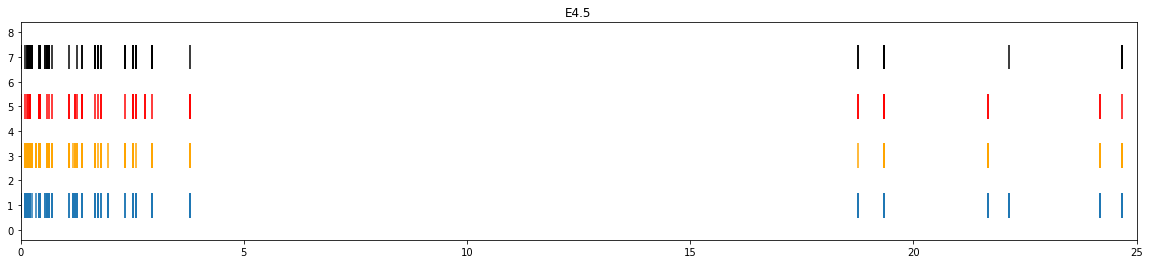

E4.5 0.01708044366100977


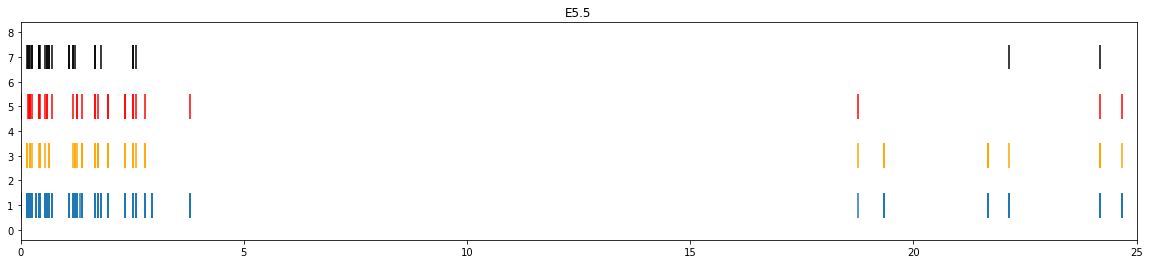

E5.5 0.17941043692347874


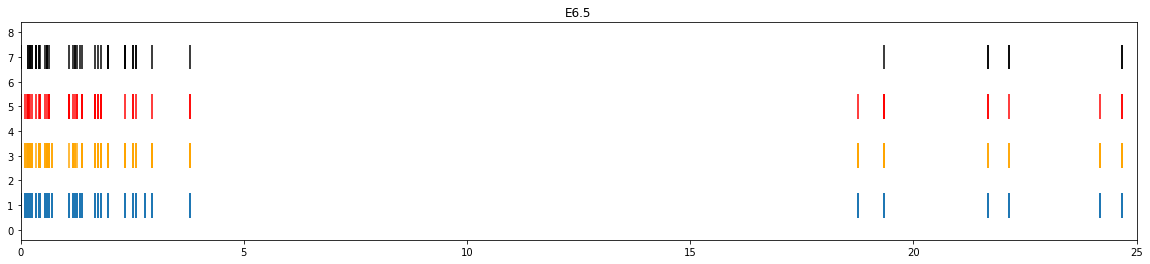

E6.5 0.10704187715749144


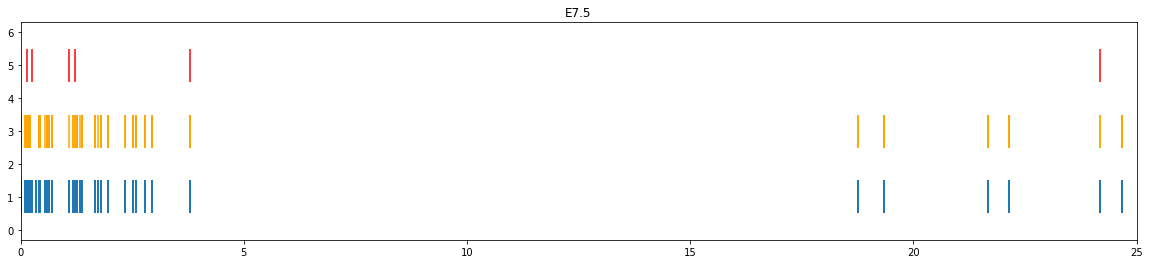

E7.5 0.08820538973227109


In [160]:
#roots positions and age
from scipy.stats import spearmanr, skew, kurtosis


sstat = []
for s in stages:
    n = len(cellinfo[s]['w']) #n cells
    ages = cellinfo[s]['age']
    meanroots = []
    plt.figure(figsize=(20,4))
    for c in range(n):
        cw = cellinfo[s]['w'][c]
        cb = cellinfo[s]['b'][c]
        cm = cellinfo[s]['m'][c]
        #masking
        cw = np.where(cm, cw, -cw)
        cb = np.where(cm, cb, 1-cb)
        cr = -cb/cw

        sort_cr = np.sort(cr)
        # crimax = cr[cr >= interval_of_search[1]].min()
        # crimin = cr[cr <= interval_of_search[0]].max()
        crimax = sort_cr[sort_cr >= interval_of_search[1]]
        crimin = sort_cr[sort_cr <= interval_of_search[0]]
        rmean =  np.concatenate([crimax, crimin]).mean()
        #rmean = (crimax + crimin)/2
        rmean = np.median(np.diff(crimin))
        meanroots.append(rmean)
        if 0 < ages[c] <= 5:
            plt.eventplot(cr)
        elif 5 < ages[c] <= 10:
            plt.eventplot(cr, lineoffsets=3, color='orange')
        elif 10 < ages[c] <= 15:
            plt.eventplot(cr, lineoffsets=5, color='red')
        else:
            plt.eventplot(cr, lineoffsets=7, color='black')
        
        plt.xlim(0, 25)
    plt.title(s)
    plt.show()
    r = spearmanr(meanroots, ages)[0]

    
    #plt.scatter(ages, meanroots)
    #plt.show()
    print(s, r)
    

In [ ]:
#ff = lambda x: np.sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
#ff = lambda x: np.prod([(wi*x + bi) for wi, bi in zip(w, b)])
#df = lambda x: np.sum([wi/(wi*x + bi) for wi, bi in zip(w, b)])

# Construct common dataframe

In [35]:
#get all common sites 
clocks = pd.read_csv('clock_data/Thompson_Multi_BL6.tsv', sep='\t', index_col=0)
top_idx = clocks['PearsonR'].abs().sort_values(ascending=False).index#[:top].index
top_sites = clocks.loc[top_idx]
#get weights and biases
w_initial = np.asarray(top_sites['Coef'])
b_initial = np.asarray(top_sites['Intercept'])

meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

common_sites = set(top_sites.index.tolist())
for stage in stages:
    i = 0
    stage_cells = meta[meta['stage'] == stage].index
    for cell_name in tqdm(stage_cells):
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        #coverage check
        if cell_df.shape[0] < 1_000_000: continue
        i+=1  
        common_sites = common_sites.intersection(cell_df.index.tolist())
        if len(common_sites) < 2:
            print('oops!')
    print(stage, i, 'passed')

100%|██████████| 133/133 [00:48<00:00,  2.75it/s]


E4.5 38 passed


100%|██████████| 134/134 [01:02<00:00,  2.15it/s]


E5.5 70 passed


100%|██████████| 195/195 [01:26<00:00,  2.27it/s]


E6.5 95 passed


100%|██████████| 296/296 [01:25<00:00,  3.46it/s]

E7.5 80 passed


In [37]:
pd.DataFrame(index=list(common_sites)).to_csv('tmp_sites_1Mcov.csv')

In [39]:
clocks.loc[list(common_sites)].sort_values('PearsonP')

,PearsonR,PearsonP,Coef,Intercept
ChrPos,,,,
chr17_39844651,0.217172,0.002232,0.001709,0.155525
chr17_39844670,0.196423,0.005793,0.001474,0.154193
chr17_39844637,0.194525,0.006294,0.002765,0.377150
chr17_39845192,0.180995,0.011126,0.001560,0.158421
chr17_39845431,0.155413,0.029623,0.001066,0.144679
chr17_39844510,0.121394,0.090091,0.001067,0.195613
chr17_39844498,0.114237,0.110866,0.000962,0.186803
chr17_39845859,0.109777,0.126583,0.002463,0.200249
chr17_39843298,0.102729,0.151913,0.001694,0.296365


# Ploynomial intuition test

In [7]:
from utils.utils import get_max
from scipy.signal import argrelextrema

def get_polynom(x, roots, sign=1):
    ff = lambda x: np.prod([(x - r) for r in roots])
    return sign * np.asarray([ff(xi) for xi in x])

In [8]:

#extrema = argrelextrema(np.array(y), np.greater, mode='wrap')[0]
#num_max = [x[0], num_max, x[-1]][np.argmax([ff(z[0]), ff(num_max), ff(z[-1])])] #include boundaries

In [30]:
def boundaries(r1, r2, n, k):
    """
    Adopted from https://www.jstor.org/stable/2313625
    """
    left = r1 + (r2 - r1)/(n - k + 1)
    right = r2 - (r2 - r1)/(k + 1)
    return left, right

max at: [1.47447447]
Boundaries: (1.3333333333333333, 1.6666666666666667)


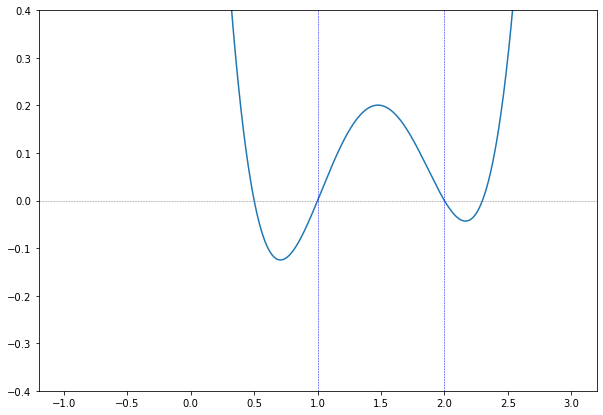

In [42]:
roots = np.array([0.5, 1, 2, 2.3])


x = np.linspace(-1, 3, 1000)
y = get_polynom(x, roots=roots, sign=1)

extrema = argrelextrema(y, np.greater, mode='wrap')[0]
crit = x[extrema]
print("max at:", crit[(crit < 2.0) & (crit > 1)])
print('Boundaries:', boundaries(r1=roots[1], r2=roots[2], n=len(roots), k=2))

plt.figure(figsize=(10,7))
plt.plot(x, y)
plt.ylim([-0.4, 0.4])
plt.axhline(0, lw=0.5, ls='--', color='grey')
plt.axvline(1.0, lw=0.5, ls='--', color='blue')
plt.axvline(2.0, lw=0.5, ls='--', color='blue');

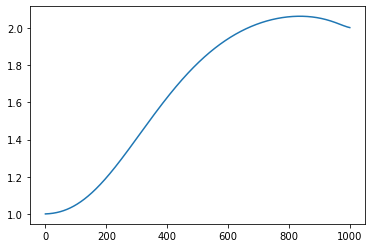

In [228]:
x = np.linspace(1.01, 1.99, 1000)
barycenter = lambda x, roots: np.sum([r / (x - r)**2 for r in roots]) / np.sum([1 / (x - r)**2 for r in roots])
b = [barycenter(xi, roots) for xi in x]

plt.plot(b)
#plt.axhline(b[extrema[1]])

https://en.wikipedia.org/wiki/Gauss%E2%80%93Lucas_theorem

# Predictions with imputations (from two types of priors)

**First case**: prior probability of methylation is a mean global methylation probability.

In [30]:
#cell data
meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

#get weights from real clocks (from the first step)
clocks = pd.read_csv('clock_data/Thompson_Multi_BL6.tsv', sep='\t', index_col=0)

#get top n from them based on the absolute value of correlation
top = 5000
top_idx = clocks['PearsonR'].abs().sort_values(ascending=False)[:top].index
top_sites = clocks.loc[top_idx]
#get weights and biases
w_initial = np.asarray(top_sites['Coef'])
b_initial = np.asarray(top_sites['Intercept'])

#PROPER INTERVAL IN SCOPE
eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
x_intervals = get_proper_intervals(b_initial, w_initial)
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
print('Interval of search:', interval_of_search)
############

n_steps = 1000
x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        prior_prob = np.mean(cell_df[cell_name]) #estimated probability to be methylated in a given cell
        #coverage check
        if cell_df.shape[0] < 500_000: continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        diff_sites = top_sites.index.difference(cell_df.index).tolist()
        if len(common_sites) == 0: continue
        
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites][cell_name].values
        
        top_sites_diff = top_sites.loc[diff_sites][['Coef', 'Intercept']]
        w_c, b_c = top_sites_diff['Coef'].values, top_sites_diff['Intercept'].values
        mask_c = np.random.binomial(1, prior_prob, top_sites_diff.shape[0]).astype(bool)
    
        probs = []
        for i, xi in enumerate(x):
            p_obs = w_ * xi + b_
            p_unobs = w_c * xi + b_c
            assert not ((p_obs <= 0).any() or (p_obs >= 1).any()), 'oops!'
            assert not ((p_unobs <= 0).any() or (p_unobs >= 1).any()), 'oops!'
            p_obs = np.where(mask, p_obs, 1-p_obs)
            p_unobs = np.where(mask_c, p_unobs, 1-p_unobs)
            p = np.log(p_obs).sum() + np.log(p_unobs).sum()
            probs.append(p)

        cell_ages.append(x[np.argmax(probs)])
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(prior_prob)
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

Interval of search: (3.8069075679530813, 18.743134560517827)


100%|██████████| 296/296 [02:20<00:00,  2.11it/s]


In [33]:
print(data.groupby('Stage').count().iloc[:, 0])
data.groupby('Stage').median()

Stage
E4.5     94
E5.5    101
E6.5    145
E7.5    155
Name: Ages, dtype: int64


,Ages,n_sites,p_empiric,p_empiric_full_cell
Stage,,,,
E4.5,18.743135,123.0,0.061656,0.259600
E5.5,18.743135,145.0,0.135135,0.726224
E6.5,18.743135,234.0,0.128788,0.768323
E7.5,18.743135,264.0,0.119048,0.747360


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

E4.5 v.s. E5.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.576e-03 U_stat=3.870e+03
E5.5 v.s. E6.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.010e-03 U_stat=6.698e+03
E6.5 v.s. E7.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.330e-01 U_stat=1.108e+04


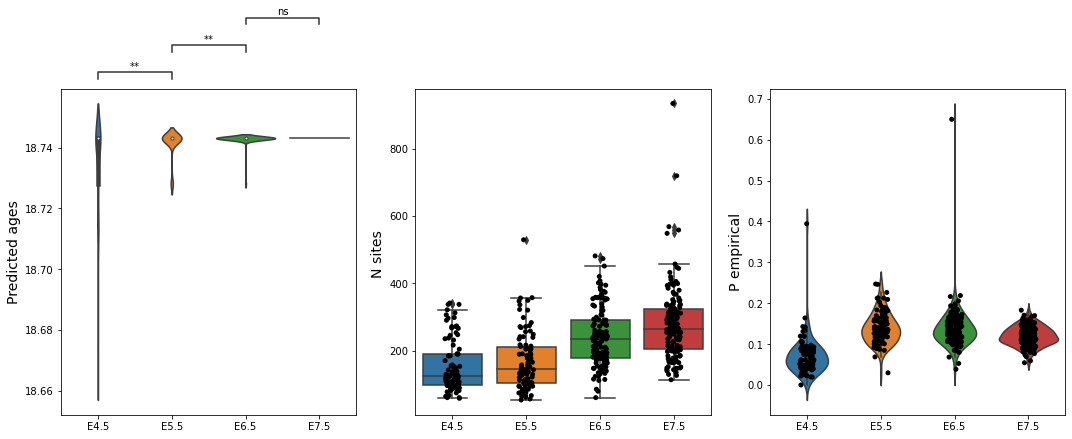

In [31]:
from statannot import add_stat_annotation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('E4.5', 'E5.5'), 
                                              ('E5.5', 'E6.5'),
                                              ('E6.5', 'E7.5')
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

(array([  5.,   2.,   2.,   2., 129.,  53.,  22.,  11.,   4.,   2.]),
 array([-0.00744945, -0.00551649, -0.00358354, -0.00165059,  0.00028236,
         0.00221532,  0.00414827,  0.00608122,  0.00801417,  0.00994713,
         0.01188008]),
 <BarContainer object of 10 artists>)

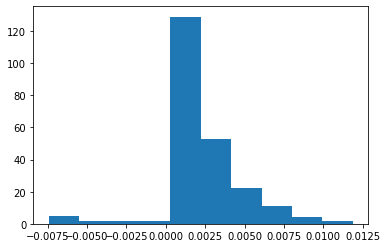

In [40]:
plt.hist(w_)

(array([177.,  20.,  11.,   6.,   2.,   5.,   2.,   2.,   5.,   2.]),
 array([-0.00333274,  0.09440236,  0.19213745,  0.28987255,  0.38760764,
         0.48534274,  0.58307783,  0.68081293,  0.77854802,  0.87628312,
         0.97401821]),
 <BarContainer object of 10 artists>)

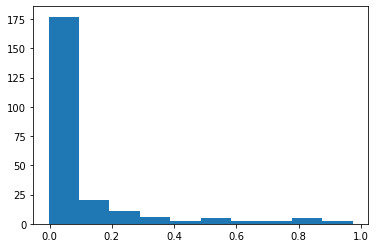

In [39]:
plt.hist(b_)

**Second case**: prior probability of methylation is mean methylation probability of a site (from reference).

In [132]:
#cell data
meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

#get weights from real clocks (from the first step)
clocks = pd.read_csv('clock_data/Thompson_Multi_BL6.tsv', sep='\t', index_col=0)

#get top n from them based on the absolute value of correlation
top = 5000
top_idx = clocks['PearsonR'].abs().sort_values(ascending=False)[:top].index
top_sites = clocks.loc[top_idx]

#get weights and biases
w_initial = np.asarray(top_sites['Coef'])
b_initial = np.asarray(top_sites['Intercept'])

#PROPER INTERVAL IN SCOPE
eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
x_intervals = get_proper_intervals(b_initial, w_initial)
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
print('Interval of search:', interval_of_search)
############

n_steps = 1000
x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        prior_prob = np.mean(cell_df[cell_name]) #estimated probability to be methylated in a given cell
        #coverage check
        if cell_df.shape[0] < 500_000: continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        diff_sites = top_sites.index.difference(cell_df.index).tolist()
        if len(common_sites) == 0: continue
        
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites][cell_name].values
        
        top_sites_diff = top_sites.loc[diff_sites][['Coef', 'Intercept']]
        w_c, b_c = top_sites_diff['Coef'].values, top_sites_diff['Intercept'].values
        mid = w_c * (interval_of_search[1] + interval_of_search[0]) / 2 + b_c
        mask_c = np.random.binomial(1, mid).astype(bool) 
    
        probs = []
        for i, xi in enumerate(x):
            p_obs = w_ * xi + b_
            p_unobs = w_c * xi + b_c
            assert not ((p_obs <= 0).any() or (p_obs >= 1).any()), 'oops!'
            assert not ((p_unobs <= 0).any() or (p_unobs >= 1).any()), 'oops!'
            p_obs = np.where(mask, p_obs, 1-p_obs)
            p_unobs = np.where(mask_c, p_unobs, 1-p_unobs)
            p = np.log(p_obs).sum() + np.log(p_unobs).sum()
            probs.append(p)

        cell_ages.append(x[np.argmax(probs)])
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(prior_prob)
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

Interval of search: (3.8069075679530813, 18.743134560517827)


100%|██████████| 296/296 [02:13<00:00,  2.22it/s]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

E4.5 v.s. E5.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.963e+03
E5.5 v.s. E6.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.608e-03 U_stat=8.980e+03
E6.5 v.s. E7.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.443e-02 U_stat=1.296e+04


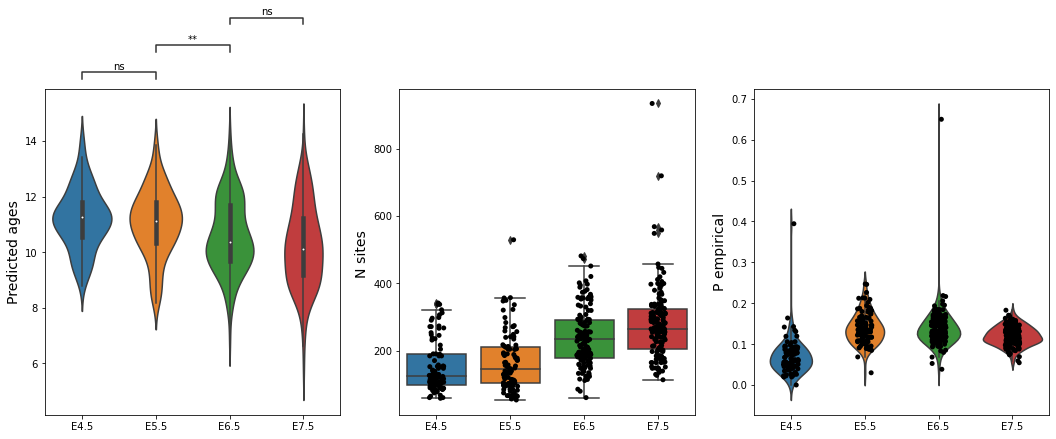

In [134]:
from statannot import add_stat_annotation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('E4.5', 'E5.5'), 
                                              ('E5.5', 'E6.5'),
                                              ('E6.5', 'E7.5')
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);